## ARIMA Modelling

ARIMA is a time series forecasting model that incorporates autocorrelation measures to model temporal structures within the time series data to predict future values. It stands for autoregression (AR), differencing (I), and moving average (MA). Each of these components corresponds to a parameter in the ARIMA model, typically denoted as (p,d,q).

p: Number of lag observations (AR).
d: Number of differencing steps to make the series stationary.
q: Number of lagged forecast errors (MA).

### Import Relevant Libraries and Data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("../data/log_stock_data.csv")
df.Date = pd.to_datetime(df.Date).dt.date

In [3]:
df.head()

,Date,LogStockValue
0,2015-01-02,3.297687
1,2015-01-09,3.271848
2,2015-01-16,3.217275
3,2015-01-23,3.244154
4,2015-01-30,3.298057


### Split data into train and test data

In [4]:
df.set_index('Date', inplace=True)

In [5]:
df.head()

,LogStockValue
Date,
2015-01-02,3.297687
2015-01-09,3.271848
2015-01-16,3.217275
2015-01-23,3.244154
2015-01-30,3.298057


In [6]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

### Check for stationarity

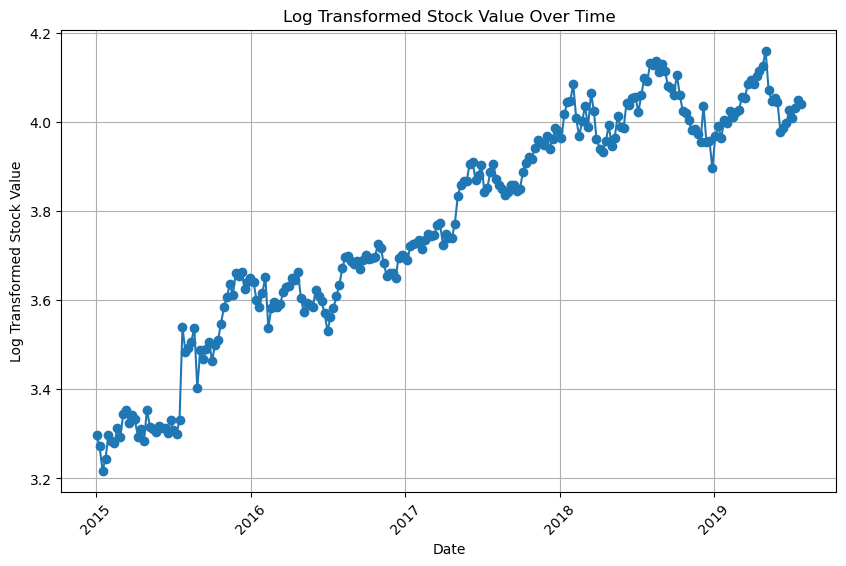

In [7]:
# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(train.index, train['LogStockValue'], marker='o')

# Adding titles and labels
plt.title('Log Transformed Stock Value Over Time')
plt.xlabel('Date')
plt.ylabel('Log Transformed Stock Value')

# Optional: Rotate x-axis labels if dates overlap
plt.xticks(rotation=45)

# Show grid for better readability
plt.grid(True)

We have an increasing stock value over time.

Now we want to check stationarity of the data because the ARMA can only model stationary processes. Stationarity means that the series has no correlation and collinearity with the past data. 

From the graph above we can already guess that there is a correlation with past data but to be sure we can use  an Augmented Dickey-Fuller (ADF) test where the null hypothesis states the null hypothesis that the series is non-stationary.

In [8]:
# Perform ADF test
adf_result = adfuller(train.LogStockValue)

# Output the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -1.9324869610651765
p-value: 0.3169358875148431
Critical Values:
	1%: -3.4583663275730476
	5%: -2.8738660999177132
	10%: -2.5733390785693766


The p-value is greater than 0.05, so we cannot reject the null hypothesis which indicates the series is likely not stationary. So we have to make the time series stationary. 

### Figuring out parameter d: Number of differentiating steps to make time series stationary

The most common method to make a time series stationary is differencing. To determine how many times we need to differentiate, i.e. the parameter d, we can use the Autocorrelation function (ACF). 

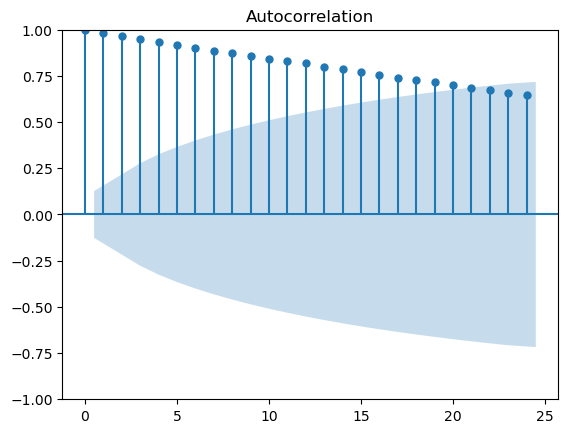

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train)

plt.show()

From the graph we can see, that is not ideal for ARIMA, let's differentiate the data and see how the autocorrelaton changes

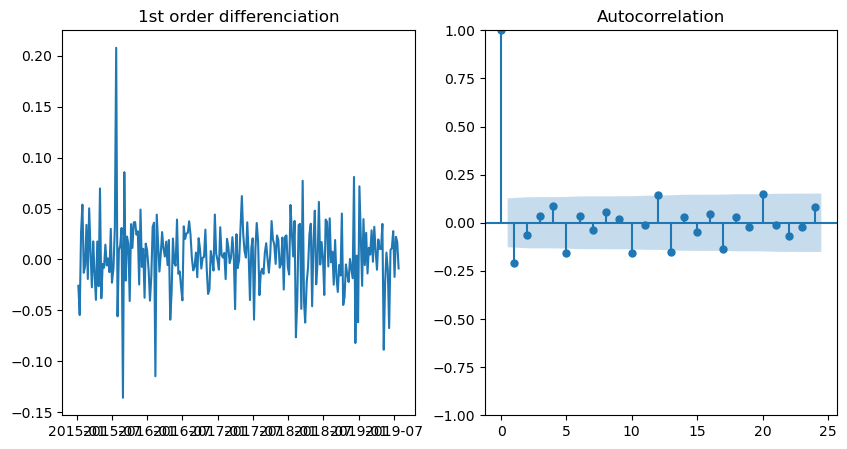

In [10]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differenciation')
ax1.plot(train.diff())

ax2 = f.add_subplot(122)
plot_acf(train.diff().dropna(), ax=ax2)
plt.show()

The differentiated data looks a lot more stationary. Although we still have some autocorrelated data. Let's do a second differentiating to check if it further improves the stationarity.

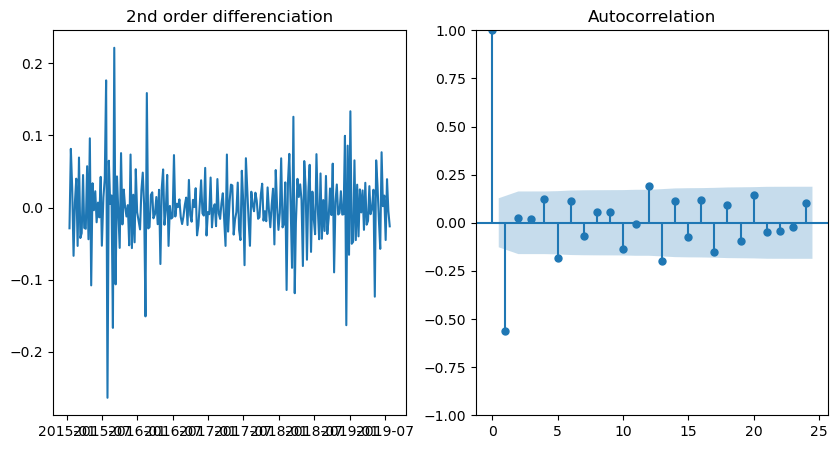

In [11]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differenciation')
ax1.plot(train.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(train.diff().diff().dropna(), ax=ax2)
plt.show()

Let's cross-check with a Augmented Dicky Fuller Test what the best oder for differentiating is

In [12]:
# Perform ADF test
#No differentiating
result1 = adfuller(train)
print('Original p-value:', result1[1])

#First order differentiating 
result2 = adfuller(train.diff().dropna())
print('1st order p-value:', result2[1])

#Second order differentiating
result3 = adfuller(train.diff().diff().dropna())
print('2nd order p-value:', result3[1])


Original p-value: 0.3169358875148431
1st order p-value: 2.7174301996052804e-11
2nd order p-value: 8.788504531998804e-13


1st order differentiating seems to be enough to make data stationary (p-value < 0.05), thus d = 1.

### Figuring out parameter p: Number of lag observations (AR)

To figure out p we can we can inspect the partial autocorrelation plot, which measures the correlation between the time-series data and a certain lag. 

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

The first two lags seems to be the most significant lags, let's differentiate the data and check again.

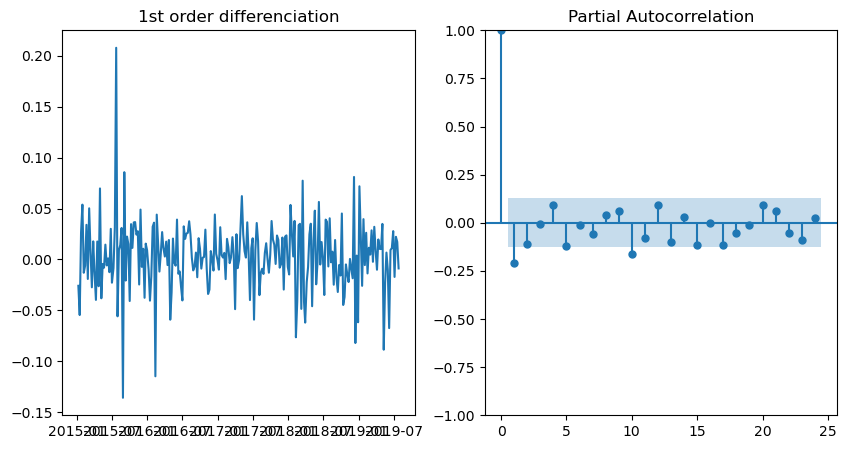

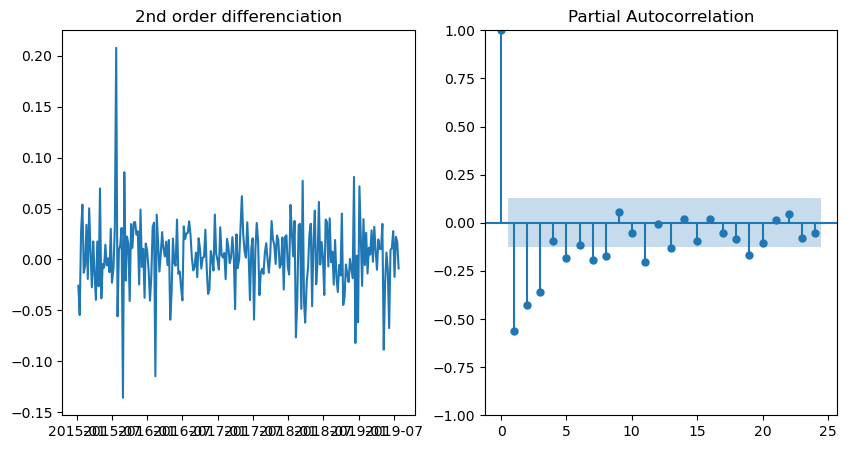

In [14]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differenciation')
ax1.plot(train.diff())

ax2 = f.add_subplot(122)
plot_pacf(train.diff().dropna(), ax=ax2)
plt.show()

f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differenciation')
ax1.plot(train.diff())

ax2 = f.add_subplot(122)
plot_pacf(train.diff().diff().dropna(), ax=ax2)
plt.show()

In both the plots, we see the 1st lag is the most significant. Thus, we consider “p” to be 1. In the second order differentiating PACF graph are too many negative values which might indicate over-differentiation.

### Figuring out parameter q : Number of lagged forecast errors (MA).

We can look at the ACF graph again. Looking at the number of lags crossing the threshold, we can determine how much of the past would be significant enough to consider for the future. Here q = 1

### Fit the ARIMA model

In [15]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train.LogStockValue, order=(1, 1, 1)) #ARIMA(p=1, d=1, q=2)

model1 = arima_model.fit()

print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:          LogStockValue   No. Observations:                  239
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 470.160
Date:                Tue, 10 Sep 2024   AIC                           -934.320
Time:                        14:54:23   BIC                           -923.903
Sample:                             0   HQIC                          -930.122
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0787      0.351      0.224      0.822      -0.609       0.767
ma.L1         -0.2987      0.349     -0.857      0.391      -0.982       0.384
sigma2         0.0011   5.17e-05     21.788      0.0

/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The AR(L1) and MA(L1)terms all have p-values greater than 0.5, suggesting that these coefficients may not be statistically significant. This could imply that the model might not be capturing the underlying process effectively or that the chosen orders for AR and MA terms might not be optimal.

Let's try with second order differentiating. And if it doesn't give better results, we can try the SARIMA model where seasonality is also captured. 

In [16]:
arima_model2 = ARIMA(train.LogStockValue, order=(1, 2, 1)) #ARIMA(p=1, d=2, q=2)

model2 = arima_model2.fit()

print(model2.summary())

/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          LogStockValue   No. Observations:                  239
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 465.482
Date:                Tue, 10 Sep 2024   AIC                           -924.964
Time:                        14:54:23   BIC                           -914.560
Sample:                             0   HQIC                          -920.771
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2069      0.059     -3.502      0.000      -0.323      -0.091
ma.L1         -0.9999      1.378     -0.726      0.468      -3.700       1.700
sigma2         0.0011      0.002      0.728      0.4

Here the AR coefficient is significant.

Let's try to find the best values with the pmdarima library designed to automate the process of building ARIMA  models for time series forecasting with the best parameters

#### PMDARIMA Library 

In [29]:
import pmdarima as pmd

pmd.auto_arima(train,
               trace=True,
               error_action='ignore',  # don't want to know if an order does not work
               suppress_warnings=True,  # don't want convergence warnings
               stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-934.165, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-926.991, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-935.769, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-937.842, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-927.028, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-936.159, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-936.295, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-935.687, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-936.199, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.208 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [30]:
arima_model3 = ARIMA(train.LogStockValue, order=(0, 1, 1)) #ARIMA(p=0, d=1, q=1)

model3 = arima_model3.fit()

print(model3.summary())

                               SARIMAX Results                                
Dep. Variable:          LogStockValue   No. Observations:                  239
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 470.100
Date:                Tue, 10 Sep 2024   AIC                           -936.199
Time:                        14:55:15   BIC                           -929.255
Sample:                             0   HQIC                          -933.400
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2214      0.062     -3.570      0.000      -0.343      -0.100
sigma2         0.0011   4.92e-05     22.909      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.04   Jarque-

Now all our coefficients are significant. To crosscheck results let's do a GridSearch to find the best combination of ARIMA parameters.

#### GridSearch

In [31]:
import itertools
import warnings
from sklearn.metrics import mean_squared_error

# Define the p, d, q parameters for ARIMA
p = range(0, 4)
d = range(0, 4)
q = range(0, 4)

# Generate all combinations of p, d, q triplets
pdq = list(itertools.product(p, d, q))

# Suppress warnings
warnings.filterwarnings("ignore")

best_aic = np.inf
best_params = None
best_model = None

# Loop through all combinations of pdq and seasonal_pdq
for param in pdq:
    try:
        model = ARIMA(train.LogStockValue, order=param)
        results = model.fit()

        if results.aic < best_aic:
            best_aic = results.aic
            best_params = (param)
            best_model = results

            print(f'ARIMA{param} - AIC:{results.aic}')
    except:
        continue

# Print the best parameters
print(f'\nBest ARIMA Model: ARIMA({best_params})- AIC:{best_aic}')

# Make predictions using the best model
forecast = best_model.get_forecast(steps=10)
predicted_mean = forecast.predicted_mean
print(predicted_mean)


ARIMA(0, 0, 0) - AIC:20.83258406353467
ARIMA(0, 0, 1) - AIC:-247.23218992680194
ARIMA(0, 0, 2) - AIC:-458.6863738101515
ARIMA(0, 0, 3) - AIC:-545.6421706710283
ARIMA(0, 1, 0) - AIC:-927.0276251098808
ARIMA(0, 1, 1) - AIC:-936.1992472177124
ARIMA(2, 1, 2) - AIC:-939.2166009240572
ARIMA(2, 1, 3) - AIC:-939.3844628126876

Best ARIMA Model: ARIMA((2, 1, 3))- AIC:-939.3844628126876
239    4.023786
240    4.025199
241    4.040591
242    4.040103
243    4.025355
244    4.024995
245    4.039079
246    4.040213
247    4.026807
248    4.024971
Name: predicted_mean, dtype: float64


In [32]:
arima_model4 = ARIMA(train.LogStockValue, order=(2, 1, 3)) #ARIMA(p=2, d=1, q=3)

model4 = arima_model4.fit()

print(model4.summary())

                               SARIMAX Results                                
Dep. Variable:          LogStockValue   No. Observations:                  239
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 475.692
Date:                Tue, 10 Sep 2024   AIC                           -939.384
Time:                        14:55:27   BIC                           -918.551
Sample:                             0   HQIC                          -930.988
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0561      0.039      1.445      0.148      -0.020       0.132
ar.L2         -0.9564      0.039    -24.744      0.000      -1.032      -0.881
ma.L1         -0.2776      0.077     -3.592      0.0

###  Predictions with parameters suggested by pmdarima library

In [33]:
n_steps = len(test) 
forecast = model3.forecast(steps=n_steps)

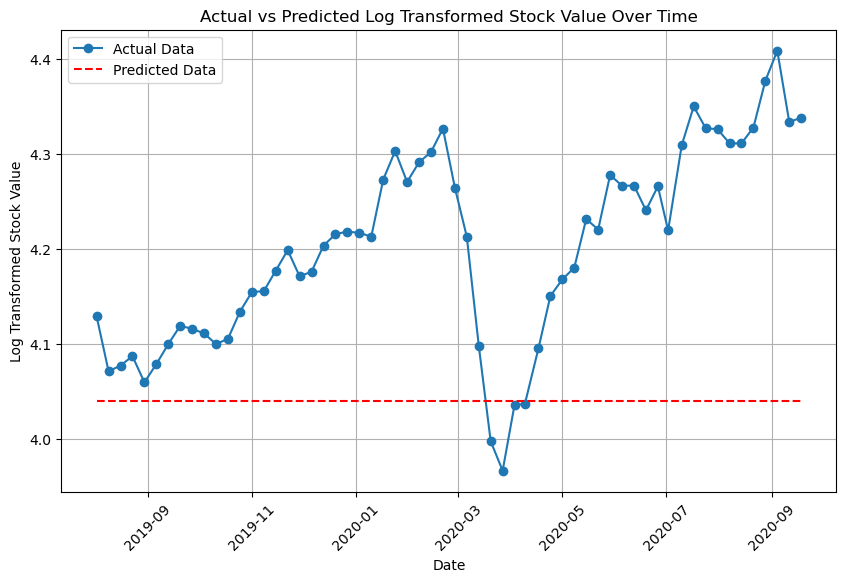

In [34]:
# Convert the index to a format suitable for plotting 
forecast.index = test.index 

# Plot the actual data
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['LogStockValue'], marker='o', label='Actual Data')

# Plot the predicted (forecasted) data
plt.plot(forecast.index, forecast, color='red', label='Predicted Data', linestyle='--')

# Adding titles and labels
plt.title('Actual vs Predicted Log Transformed Stock Value Over Time')
plt.xlabel('Date')
plt.ylabel('Log Transformed Stock Value')

# Optional: Rotate x-axis labels if dates overlap
plt.xticks(rotation=45)

# Show grid and legend for better readability
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

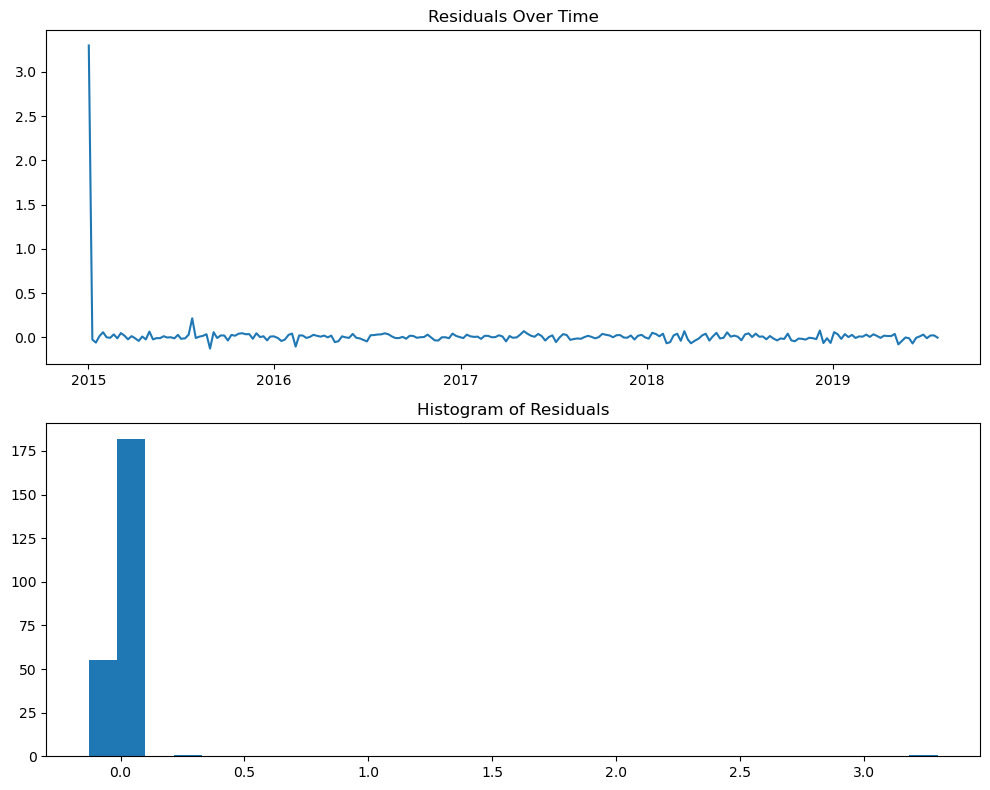

In [35]:
#Plot residuals

residuals = model3.resid

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot the residuals over time
ax[0].plot(residuals)
ax[0].set_title('Residuals Over Time')

# Plot the histogram of residuals
ax[1].hist(residuals, bins=30)
ax[1].set_title('Histogram of Residuals')

plt.tight_layout()
plt.show()

Residuals Over Time: The residuals seem to fluctuate around zero and remain relatively constant over time, suggesting that there are no major trends or patterns left in the residuals. However, there is an outlier early in the series that may warrant further investigation.

Histogram of Residuals: The residuals are concentrated around zero, but the distribution appears to be somewhat skewed, indicating potential non-normality, which aligns with the Jarque-Bera test results from the model summary.

Let's check normality of residuals' distribution 

6.47789017087727e-32


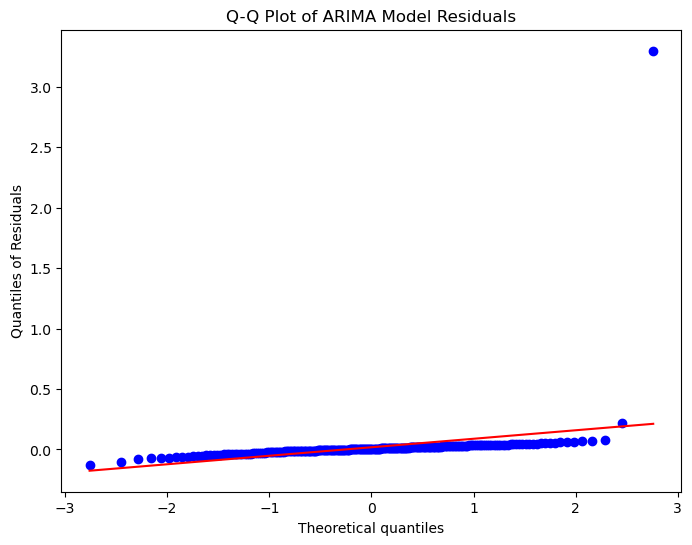

In [36]:
import scipy.stats as stats

# Get the residuals
residuals = model3.resid

# Perform Shapiro-Wilk test for normality on the residuals
_,shapiro_p_value = stats.shapiro(residuals)

# Output the results of the test
print(shapiro_p_value)

# Generate a Q-Q plot for the residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of ARIMA Model Residuals')
plt.ylabel('Quantiles of Residuals')
plt.show()

The p-value from the Shapiro-Wilk test is very small, so we can reject the null hypothesis that distribution is normal. 

From the q-q plot, we also can see that there is some deviation from normality, particularly in the tails, which indicates that the residuals may not be perfectly normally distributed.

Non-normal residuals might indicate that the model hasn't captured all the patterns in the data, such as volatility or extreme values.

###  Predictions with parameters suggested by GridSearch

In [37]:
n_steps = len(test) 
forecast = model4.forecast(steps=n_steps)

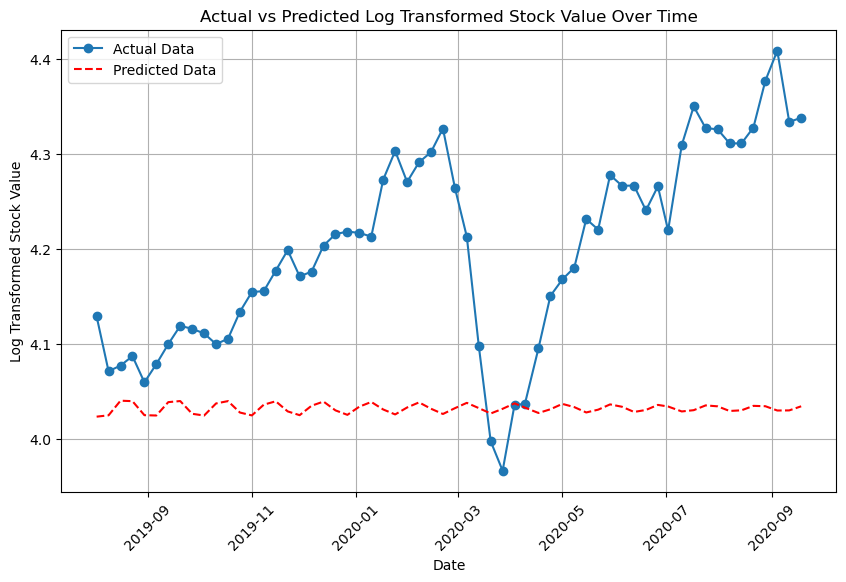

In [38]:
# Convert the index to a format suitable for plotting 
forecast.index = test.index 

# Plot the actual data
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['LogStockValue'], marker='o', label='Actual Data')

# Plot the predicted (forecasted) data
plt.plot(forecast.index, forecast, color='red', label='Predicted Data', linestyle='--')

# Adding titles and labels
plt.title('Actual vs Predicted Log Transformed Stock Value Over Time')
plt.xlabel('Date')
plt.ylabel('Log Transformed Stock Value')

# Optional: Rotate x-axis labels if dates overlap
plt.xticks(rotation=45)

# Show grid and legend for better readability
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

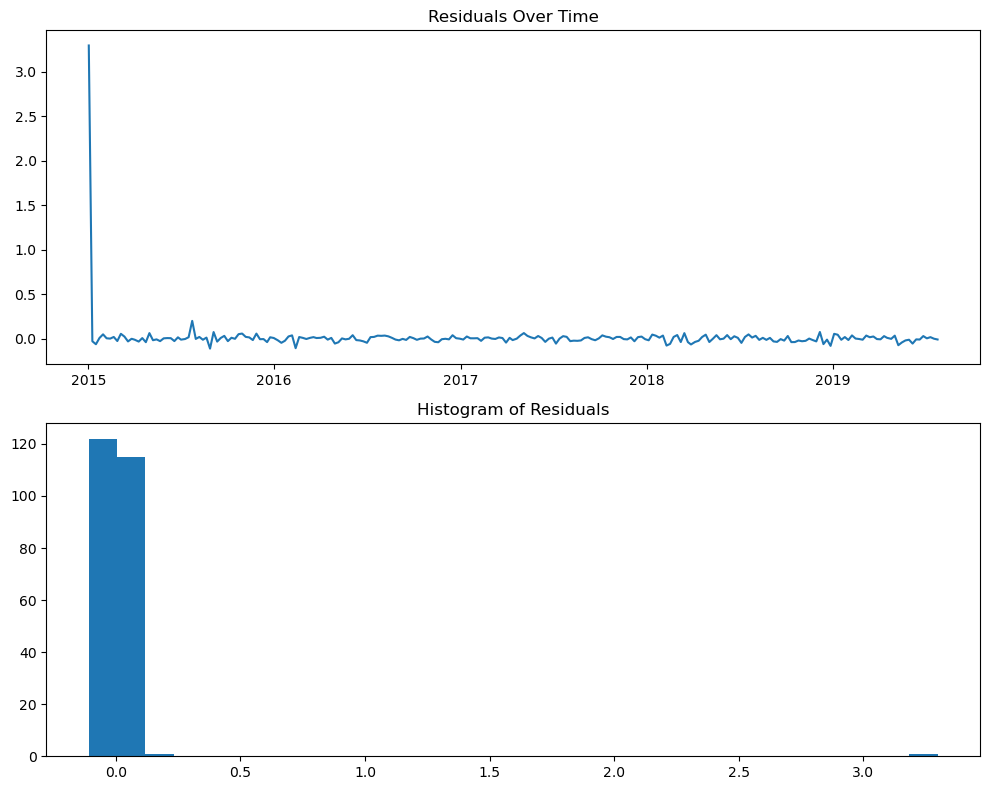

In [39]:
# Plot the residual diagnostics of the ARIMA model
residuals = model4.resid

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot the residuals over time
ax[0].plot(residuals)
ax[0].set_title('Residuals Over Time')

# Plot the histogram of residuals
ax[1].hist(residuals, bins=30)
ax[1].set_title('Histogram of Residuals')

plt.tight_layout()
plt.show()

Residuals Over Time: As before the residuals seem to fluctuate around zero and remain relatively constant over time, suggesting that there are no major trends or patterns left in the residuals.We also can observe the outlier early in the series that may warrant further investigation.

Histogram of Residuals: The results are very similar to what we got before.

6.216906915107706e-32


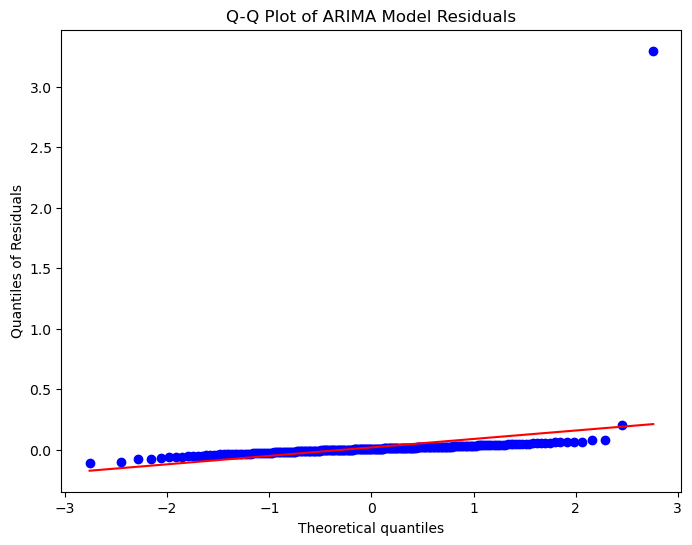

In [40]:
# Get the residuals
residuals = model4.resid

# Perform Shapiro-Wilk test for normality on the residuals
_,shapiro_p_value = stats.shapiro(residuals)

# Output the results of the test
print(shapiro_p_value)

# Generate a Q-Q plot for the residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of ARIMA Model Residuals')
plt.ylabel('Quantiles of Residuals')
plt.show()

Same as in previous model, from the Shapiro Wilk test and the q-q plot of the residuals, we can conclude that the residuals are not distributed normally.

### Conclusion

As we can see from the graph both of the models we used for forescating do not perform vert well.

An explanation might be that they are exogenous factors we don't take into consideration. More precisely, in both of the models we used for forecasting we can observe that the residuals are not distributed normally. While this is not a requirement for ARIMA modelling it might indicate however that the model hasn't captured all the patterns in the data, such as volatility or extreme values.

Maybe we do not capture an underlying seasonal trend. Let's try the SARIMA model (see SARIMA_modelling notebook).